In [1]:
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

In [2]:
'''
This function will run each individual trial.
'''
def runTrial(n):
    # Make an empty list and initialize the count
    sample_list = []
    count = 0

    # Keep looping until successful return call
    while(True):
        # generate random int between 0, n
        x = randint(0, n)
        
        # increment the count of randomly generated numbers
        count = count + 1
        
        # if x is already in sample list return the count
        if x in sample_list:
            return count
        # else add x to the list
        else:
            sample_list.append(x)
    return

In [3]:
'''
This function conducts the entire simulation.
'''
def birthdayParadox(n, m):
    # initialize an empty list
    full_list = []
    
    # run m individual trials and append results
    # to the full_list
    i = 0
    for i in range(m):
        full_list.append(runTrial(n))

    return full_list

In [10]:
'''
This function takes a list of values and derives the PDF.
The PDF is then returned in a dictionary structure.
'''
def probabilityDensityFunction(arg_list):
    # convert list to dictionary
    # with keys being the list elements
    # and values being the count of element appearnces in list
    result_count = Counter(result)
    
    # get the total number of observations
    total = sum(result_count.values(), 0.0)
    
    # divide each value in dictionary by total
    regularized_count = {k: v / total for k, v in result_count.items()}
    
    return regularized_count

In [51]:
'''
This function takes a PDF dictionary and returns
an ordered Pandas DataFrame with an additional 
column for cumulative probabilities.
'''
def cdfDataFrame(prob_dic):
    # converting the dicitonary to a 2 column numpy array
    df = np.array([[k,v] for k,v in prob_dic.items()])
    
    # sort the 2 column array for values in column 0
    df = df[df[:, 0].argsort()]
    
    # calculate the cumulative sum of the second column
    cdf = np.cumsum(df[:, 1])
    
    # now make a pandas dataframe
    data = pd.DataFrame({'Values': df[:, 0],
                         'Probability': df[:, 1],
                         'Cumulative Probability': cdf})
    
    return data

In [52]:
# run the entire simulation with specified arguments
result = birthdayParadox(n=5000, m=300)

In [53]:
# calculate the expected value
expected_v = sum(result) / len(result)
print("Expected value: ", expected_v)

Expected value:  87.27333333333333


In [54]:
# get the pdf
pdf = probabilityDensityFunction(result)

In [55]:
# get the cdf dataframe
cdf_df = cdfDataFrame(pdf)

In [57]:
# view the data
cdf_df

,Values,Probability,Cumulative Probability
0,3.0,0.003333,0.003333
1,7.0,0.006667,0.010000
2,11.0,0.003333,0.013333
3,13.0,0.006667,0.020000
4,14.0,0.003333,0.023333
...,...,...,...
132,190.0,0.003333,0.986667
133,194.0,0.003333,0.990000
134,198.0,0.003333,0.993333
135,211.0,0.003333,0.996667


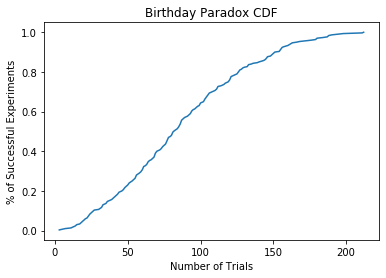

In [59]:
# generate a plot
plt.plot(cdf_df['Values'],
         cdf_df['Cumulative Probability'])

#a add some labels for clarity
plt.xlabel("Number of Trials")
plt.ylabel("% of Successful Experiments")
plt.title("Birthday Paradox CDF")

plt.show()